In [ ]:
Outline:
0. Example
1. Computation is easy, testing is hard: need to create files, etc.
2. Suppose we want to aggregate over TV, VOD => lots of redundant code
3. Extract iteration over chunks
4. Extract removal of month: show how to chain iterators, leave as exercise
4. Add progressbar
5. We want to do better and remove all redundancy: generator that takes a list of filenames and return chunks. Need to introduce zip and other built-in generators
6. `dask` version

In [1]:
%matplotlib inline

import pandas as pd

In [ ]:
# HERE show what is in the files, and what a DataFrame looks like

In [2]:
year = 2017
months = [10, 11, 12]
template = 'consumption_{year}{month}.csv'
chunksize = 10

chunks = []
for month in months:
    filename = template.format(year=year, month=month)
    print(filename)

    chunk_iterator = pd.read_csv(filename, sep=',', chunksize=chunksize)
    for chunk in chunk_iterator:
        chunk.columns = chunk.columns.str.replace('{year}{month}_'.format(year=year, month=month), '')
        
        chunk_sum = pd.DataFrame(
            data={
                'MORNING': chunk['TV_M'] + chunk['VOD_M'],
                'AFTERNOON': chunk['TV_A'] + chunk['VOD_A'],
                'NIGHT': chunk['TV_N'] + chunk['VOD_N'],
                'USER_ID': chunk['USER_ID'],
                'YEAR_MONTH': month,
            }
        )
        chunks.append(chunk_sum)

df = pd.concat(chunks)

consumption_201710.csv
consumption_201711.csv
consumption_201712.csv


In [3]:
df.head()

,AFTERNOON,MORNING,NIGHT,USER_ID,YEAR_MONTH
0,3468,2582,7090,0,10
1,3211,2483,6816,1,10
2,1959,1403,3448,2,10
3,1722,1568,4450,3,10
4,605,457,1338,4,10


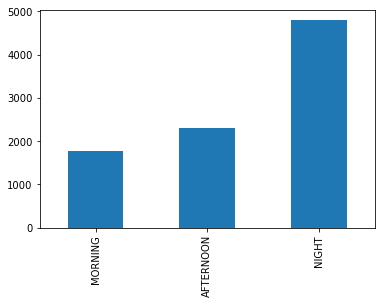

In [4]:
df.loc[:, ['MORNING', 'AFTERNOON', 'NIGHT']].mean().plot.bar()

Here what the code aggregating over TV, VOD would look like

In [ ]:
# what we would like to write instead

df = pd.concat(
    aggregated_chunk
    for aggregated_chunk in aggregate_part_of_day(load_clean_chunk(months))
)

df = pd.concat(
    aggregated_chunk
    for aggregated_chunk in aggregate_service(load_clean_chunk(months))
)


In [ ]:
load_clean_chunk = iterate_chunks(filename, chunksize=chunksize))

In [47]:
# ??? clean_columns needs `month`
for month, chunk in zip(months, clean_columns(iterate_chunks(months_to_filename(months, 2017), chunksize=chunksize)):
    chunk.columns = chunk.columns.str.replace(str(month) + '_', '')


SyntaxError: invalid syntax (<ipython-input-47-50fcb5f621c3>, line 2)

In [40]:
chunk

,USER_ID,TV_201710_M,TV_201710_A,TV_201710_N,VOD_201710_M,VOD_201710_A,VOD_201710_N
10,10,926,1362,2302,668,690,1972
11,11,316,433,721,1215,1208,3517
12,12,1483,2049,3428,638,680,1862
13,13,306,487,887,1397,1487,4256
14,14,462,679,1049,138,148,464
15,15,823,1216,2011,740,689,2201
16,16,1914,2761,4415,375,377,1228
17,17,217,373,610,1333,1250,3867
18,18,798,1116,1866,493,498,1589
19,19,2012,3080,4808,1024,1004,2922


In [52]:
# This works, but very specific:

def iterate_months_in_chunks(months, year, chunksize):
    for month in months:
        template = 'consumption_{year}{month}.csv'
        filename = template.format(month=month, year=year)

        chunk_iterator = pd.read_csv(filename, sep=',', chunksize=chunksize)
        for chunk in chunk_iterator:
            chunk.columns = chunk.columns.str.replace('{year}{month}_'.format(year=year, month=month), '')
            yield chunk

In [53]:
year = 2017
months = [10, 11, 12]
template = 'consumption_{year}{month}.csv'
chunksize = 10

chunks = []
for chunk in iterate_months_in_chunks(months, year, chunksize=chunksize):
    chunk_sum = pd.DataFrame(
        data={
            'MORNING': chunk['TV_M'] + chunk['VOD_M'],
            'AFTERNOON': chunk['TV_A'] + chunk['VOD_A'],
            'NIGHT': chunk['TV_N'] + chunk['VOD_N'],
            'USER_ID': chunk['USER_ID'],
            'YEAR_MONTH': month,
        }
    )
    chunks.append(chunk_sum)

df = pd.concat(chunks).set_index(['USER_ID', 'YEAR_MONTH'])

In [75]:
year = 2017
months = [10, 11, 12]
template = 'consumption_{year}{month}.csv'
chunksize = 10

def iterate_files_in_chunks(filenames, chunksize, *args):
    for filename, arg in zip(filenames, args[0]):
        chunk_iterator = pd.read_csv(filename, sep=',', chunksize=chunksize)
        for chunk in chunk_iterator:
            yield chunk, arg
            
def months_to_filename(months, year):
    template = 'consumption_{year}{month}.csv'
    for month in months:
        yield template.format(month=month, year=year)

def clean_chunks(chunks):
    for chunk in chunks:
        print(chunk)
        chunk.columns = chunk.columns.str.replace('{year}{month}_'.format(year=year, month=month), '')
        yield chunk

chunks = []
for chunk in clean_chunks(
        iterate_files_in_chunks(months_to_filename(months, year), chunksize, months, [year, year, year])):
    chunk_sum = pd.DataFrame(
        data={
            'MORNING': chunk['TV_M'] + chunk['VOD_M'],
            'AFTERNOON': chunk['TV_A'] + chunk['VOD_A'],
            'NIGHT': chunk['TV_N'] + chunk['VOD_N'],
            'USER_ID': chunk['USER_ID'],
            'YEAR_MONTH': month,
        }
    )
    chunks.append(chunk_sum)

df = pd.concat(chunks).set_index(['USER_ID', 'YEAR_MONTH'])

(   USER_ID  TV_201710_M  TV_201710_A  TV_201710_N  VOD_201710_M  VOD_201710_A  \
0        0         1690         2515         4285           892           953   
1        1         1243         1952         3105          1240          1259   
2        2         1203         1797         2910           200           162   
3        3          312          461          787          1256          1261   
4        4          242          379          609           215           226   
5        5          279          394          677            97           106   
6        6          105          123          222           911           916   
7        7          468          677         1015           233           272   
8        8         1702         2607         4301           238           212   
9        9          547          774         1409           183           228   

   VOD_201710_N  
0          2805  
1          3711  
2           538  
3          3663  
4           729  

AttributeError: 'tuple' object has no attribute 'columns'

In [49]:
from itertools import starmap

year = 2017
months = [10, 11, 12]
template = 'consumption_{year}{month}.csv'
chunksize = 10

def iterate_months_in_chunks(months, year, chunksize):
    template = 'consumption_{year}{month}.csv'
    for month in months:
        filename = template.format(month=month, year=year)
        for chunk in pd.read_csv(filename, sep=',', chunksize=chunksize):
            yield chunk, month, year

def clean_chunk(chunk, month, year):
    chunk.columns = chunk.columns.str.replace('{year}{month}_'.format(year=year, month=month), '')
    chunk['YEAR_MONTH'] = year * 100 + month
    return chunk

def aggregate_by_part_of_day(chunk):
    chunk_sum = pd.DataFrame(
        data={
            'MORNING': chunk['TV_M'] + chunk['VOD_M'],
            'AFTERNOON': chunk['TV_A'] + chunk['VOD_A'],
            'NIGHT': chunk['TV_N'] + chunk['VOD_N'],
            'USER_ID': chunk['USER_ID'],
            'YEAR_MONTH': chunk['YEAR_MONTH'],
        }
    )
    return chunk_sum

chunks = []
for chunk in starmap(clean_chunk, iterate_months_in_chunks(months, year, chunksize)):
    chunk_sum = pd.DataFrame(
        data={
            'MORNING': chunk['TV_M'] + chunk['VOD_M'],
            'AFTERNOON': chunk['TV_A'] + chunk['VOD_A'],
            'NIGHT': chunk['TV_N'] + chunk['VOD_N'],
            'USER_ID': chunk['USER_ID'],
            'YEAR_MONTH': chunk['YEAR_MONTH'],
        }
    )
    chunks.append(chunk_sum)

df = pd.concat(chunks).set_index(['USER_ID', 'YEAR_MONTH'])

In [45]:
pd.concat(
    aggregate_by_part_of_day(chunk)
    for chunk in (clean_chunk(chunk, month, year) for chunk, month, year in iterate_months_in_chunks(months, year, chunksize))
)

,AFTERNOON,MORNING,NIGHT,USER_ID,YEAR_MONTH
0,3468,2582,7090,0,201710
1,3211,2483,6816,1,201710
2,1959,1403,3448,2,201710
3,1722,1568,4450,3,201710
4,605,457,1338,4,201710
5,500,376,984,5,201710
6,1039,1016,2925,6,201710
7,949,701,1710,7,201710
8,2819,1940,4961,8,201710
9,1002,730,1958,9,201710


In [50]:
df = pd.concat(
    aggregate_by_part_of_day(chunk)
    for chunk in starmap(clean_chunk, iterate_months_in_chunks(months, year, chunksize))
)

In [52]:
def iterate_over_clean_chunks(months, year, chunksize):
    return starmap(clean_chunk, iterate_months_in_chunks(months, year, chunksize))

df = pd.concat(
    aggregate_by_part_of_day(chunk)
    for chunk in iterate_over_clean_chunks(months, year, chunksize)
)